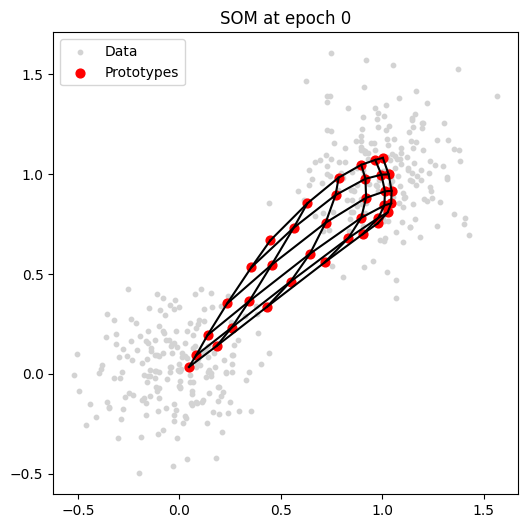

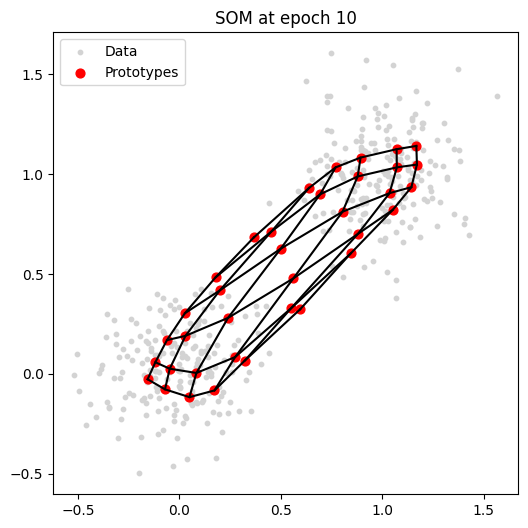

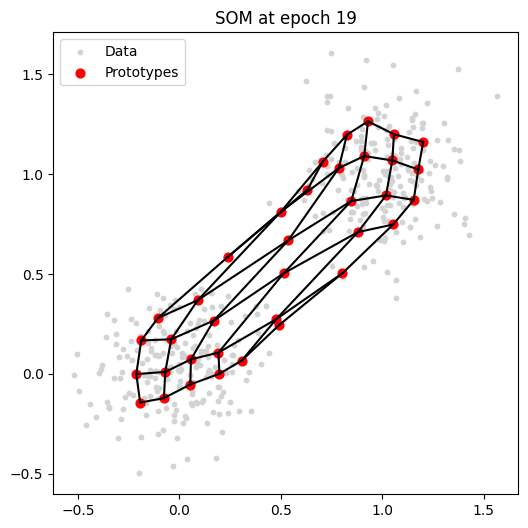

In [2]:
import torch
import matplotlib.pyplot as plt

# --- Step 1: Generate data ---
torch.manual_seed(42)
data = torch.cat([
    torch.randn(200, 2) * 0.2 + torch.tensor([0.0, 0.0]),
    torch.randn(200, 2) * 0.2 + torch.tensor([1.0, 1.0])
])

# --- Step 2: Initialize SOM prototypes (neurons) ---
grid_size = (6, 6)
prototypes = torch.rand(grid_size[0], grid_size[1], 2) * 2 - 0.5  # spread randomly

# Find Best Matching Unit (BMU)
def find_bmu(x, prototypes):
    distances = torch.norm(prototypes - x, dim=2)
    return torch.argmin(distances).div(prototypes.shape[1], rounding_mode="floor"), \
           torch.argmin(distances) % prototypes.shape[1]

# Neighborhood function (Gaussian over lattice)
def neighborhood(bmu, sigma, grid_size):
    xs, ys = torch.meshgrid(
        torch.arange(grid_size[0]),
        torch.arange(grid_size[1]),
        indexing="ij"
    )
    dist_sq = (xs - bmu[0])**2 + (ys - bmu[1])**2
    return torch.exp(-dist_sq / (2 * sigma**2))

# --- Step 3: Train SOM ---
def train_som(data, prototypes, n_epochs=10, lr=0.3, sigma=2.0, decay=0.95):
    history = []
    for epoch in range(n_epochs):
        idx = torch.randperm(data.shape[0])
        for i in idx:
            x = data[i]
            bmu = find_bmu(x, prototypes)
            neigh = neighborhood(bmu, sigma, prototypes.shape[:2])[..., None]
            prototypes += lr * neigh * (x - prototypes)
        history.append(prototypes.clone())
        # decay learning rate and neighborhood
        lr *= decay
        sigma *= decay
    return history

history = train_som(data, prototypes, n_epochs=20)

# --- Step 4: Visualization ---
def plot_som(data, prototypes, epoch):
    plt.figure(figsize=(6, 6))
    plt.scatter(data[:, 0].numpy(), data[:, 1].numpy(), c="lightgray", s=10, label="Data")
    plt.scatter(prototypes[:, :, 0].numpy(), prototypes[:, :, 1].numpy(), c="red", s=40, label="Prototypes")
    # connect prototypes in grid
    for i in range(prototypes.shape[0]):
        plt.plot(prototypes[i, :, 0].numpy(), prototypes[i, :, 1].numpy(), "k-")
    for j in range(prototypes.shape[1]):
        plt.plot(prototypes[:, j, 0].numpy(), prototypes[:, j, 1].numpy(), "k-")
    plt.title(f"SOM at epoch {epoch}")
    plt.legend()
    plt.show()

# Show first, middle, and last epochs
plot_som(data, history[0], epoch=0)
plot_som(data, history[len(history)//2], epoch=len(history)//2)
plot_som(data, history[-1], epoch=len(history)-1)
